## **XGBoost**

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of gradient boosted decision trees. It is designed for speed and performance, making it one of the most popular algorithms in machine learning competitions (e.g., Kaggle). XGBoost builds models sequentially, where each new tree corrects the errors of the previous ones, optimizing both accuracy and generalization.

#### **How It Works**
- *Gradient Boosting Framework* - Trees are built iteratively, minimizing a loss function
- *Regularization* - Includes $L_1$ (Lasso) and $L_2$ (Ridge) penalties to reduce overfitting
- *Shrinkage (Learning Rate)* - Each tree's contribution is scaled by a factor to improve generalization
- *Column Subsampling* - Randomly samples features to prevent overfitting (similarto Random Forest)
- *Parallelization* - Optimized for distributed computing, making it faster than traditional gradient boosting.

#### **Advantages**
- High predictive accuracy
- Regularization helps prevent overfitting
- Scales well to large datasets with efficient memory usage
- Flexible - supports custom loss functions and evaluation metrics

#### **Limitations**
- More complex than simpler models (e.g. Logistic Regression, Naive Bayes, etc.)
- Requires careful hyperparameters tuning for optimal performance
- Can be computationally expensive for very large-scale datasets

### **Import necessary libraries**

In [2]:
import os 
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### **Prepare train, test data**

In [3]:
train_df = pd.read_csv('/kaggle/input/diabetes-dataset/train_data.csv')
test_df = pd.read_csv('/kaggle/input/diabetes-dataset/test_data.csv')

In [4]:
X_train = train_df.drop(columns=['diabetes'])
y_train = train_df['diabetes']
X_test = test_df.drop(columns=['diabetes'])
y_test = test_df['diabetes']

### **Initialize model**

In [5]:
model = XGBClassifier()

In [6]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
y_pred = model.predict(X_test)

In [8]:
y_pred

array([0, 0, 1, ..., 1, 0, 0])

Accuracy:  0.9712413724117235
Recall:  0.6976470588235294
Precision:  0.9510825982357658
F1 Score:  0.8048863250763488


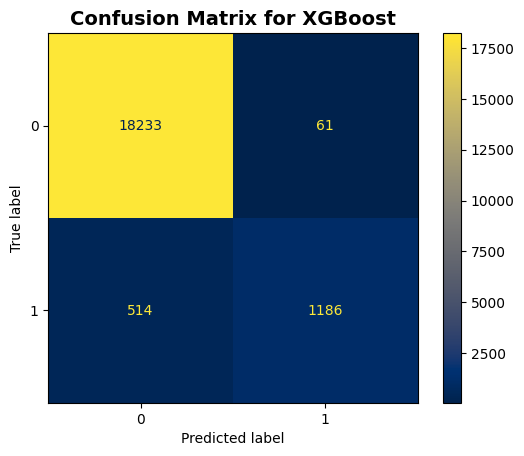

In [9]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for XGBoost", fontsize=14, weight='bold')
plt.show()

### **Fine-tune hyperparameters**

In [10]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "use_label_encoder": False,
        "eval_metric": "auc",
        'verbosity': 0
    }

    model = XGBClassifier(**params, n_jobs=-1, random_state=42)

    model.fit(
        X_train, y_train,
    )

    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100000, timeout=39600)  # 50 trials or 10 mins

print("Best parameters:", study.best_params)
print("Best CV accuracy:", study.best_value)

Best parameters: {'n_estimators': 782, 'max_depth': 12, 'learning_rate': 0.009333120474551022, 'subsample': 0.7875035475730751, 'colsample_bytree': 0.9120209185457265, 'gamma': 4.3108706300263036, 'min_child_weight': 1, 'reg_alpha': 1.4213556873200199e-05, 'reg_lambda': 5.352743316340335e-07}
Best CV accuracy: 0.9729418825647694


In [11]:
best_model = XGBClassifier(
    **study.best_params, 
    eval_metric='auc', 
    use_label_encoder=False, 
    n_jobs=-1, 
    verbosity=0,
    random_state=42
)

In [12]:
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9120209185457265, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=4.3108706300263036,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009333120474551022,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=782, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
best_y_pred = best_model.predict(X_test)

Accuracy:  0.9729418825647694
Recall:  0.6888235294117647
Precision:  0.9898562975486053
F1 Score:  0.8123482483524107


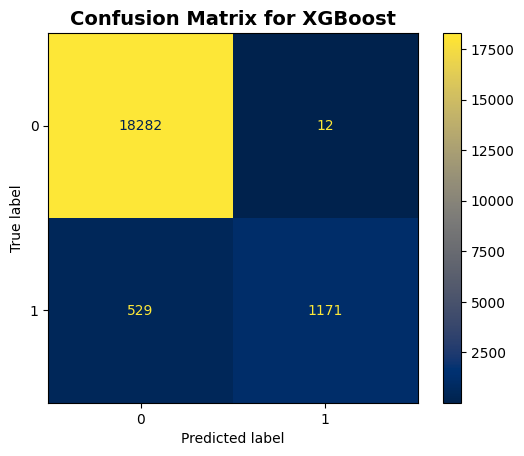

In [14]:
print("Accuracy: ", accuracy_score(y_test, best_y_pred))
print("Recall: ", recall_score(y_test, best_y_pred))
print("Precision: ", precision_score(y_test, best_y_pred))
print("F1 Score: ", f1_score(y_test, best_y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, best_y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for XGBoost", fontsize=14, weight='bold')
plt.show()

### **Save model**

In [15]:
import joblib
joblib.dump(best_model, "xgb_model.pkl")

['xgb_model.pkl']

### **Load model**

In [16]:
model = joblib.load("xgb_model.pkl")

In [17]:
y_pred = model.predict(X_test)

Accuracy:  0.9729418825647694
Recall:  0.6888235294117647
Precision:  0.9898562975486053
F1 Score:  0.8123482483524107


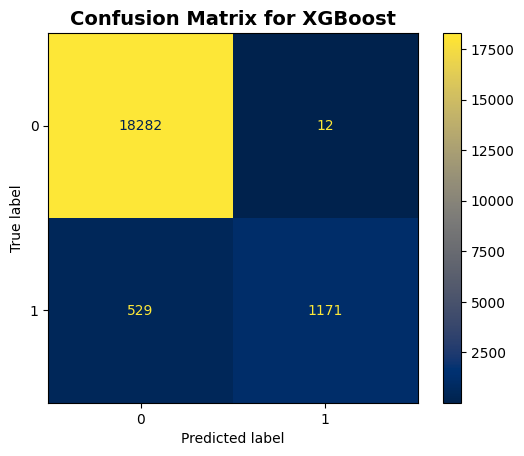

In [18]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap=plt.cm.cividis)

plt.title("Confusion Matrix for XGBoost", fontsize=14, weight='bold')
plt.show()